# Setup

In [1]:
# Display env
sys = system("cat /etc/*release", intern=TRUE)
gsub("PRETTY_NAME=","", grep("PRETTY_NAME", sys, value=TRUE))
cat(R.version$version.string,"\n")
# Use pre-compiled R packages for Linux (faster install)
options(repos=list(CRAN='https://packagemanager.posit.co/cran/__linux__/jammy/latest/'))

[1] "\"Ubuntu 22.04.3 LTS\""

R version 4.3.2 (2023-10-31) 


In [2]:
# Pre-compiled rlibkriging package (faster install)
remotes::install_url("https://github.com/libKriging/rlibkriging/releases/download/0.8-0.1/rlibkriging_0.8-0_R_x86_64-pc-linux-gnu.tar.gz", dependencies = TRUE, build=FALSE)
# for Windows: remotes::install_url("https://github.com/libKriging/rlibkriging/releases/download/0.8-0.1/rlibkriging_0.8-0.zip", dependencies = TRUE, build=FALSE)
# for OSX(intel): remotes::install_url("https://github.com/libKriging/rlibkriging/releases/download/0.8-0.1/rlibkriging_0.8-0.tgz", dependencies = TRUE, build=FALSE)
library(rlibkriging)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘rlibkriging’


The following objects are masked from ‘package:base’:

    load, save




# Basics

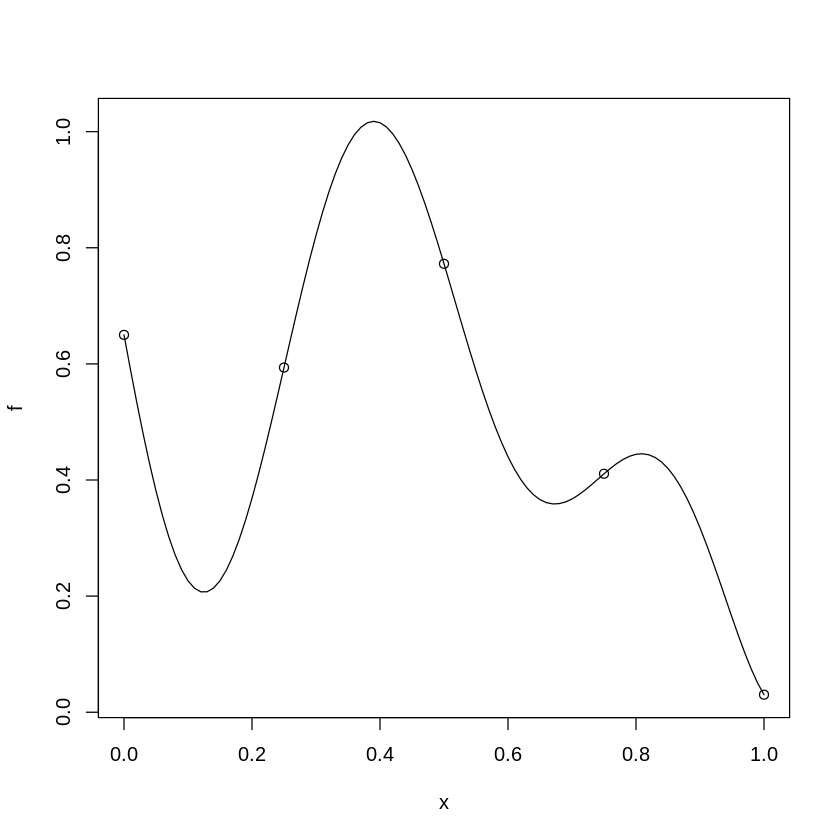

In [3]:
# 1D function, small design
X <- as.matrix(c(0.0, 0.25, 0.5, 0.75, 1.0))
f <- function(x) 1 - 1 / 2 * (sin(12 * x) / (1 + x) + 2 * cos(7 * x) * x^5 + 0.7)
y <- f(X) # + 10*rnorm(nrow(X))

plot(f)
points(X, y)

In [4]:
# Build Kriging (https://libkriging.readthedocs.io/en/latest/math/KrigingModels.html)
k <- Kriging(y, X, kernel="gauss") #, objective = "LL", optim = "BFGS", regmodel = "constant", parameters = ...)
# kernel: https://libkriging.readthedocs.io/en/latest/math/kernel.html
# regmodel: https://libkriging.readthedocs.io/en/latest/math/trend.html
# parameters: https://libkriging.readthedocs.io/en/latest/math/parameters.html
print(k)

* data: 5x[0,1] -> 5x[0.030241,0.772403]
* trend constant (est.): 0.46971
* variance (est.): 0.0786585
* covariance:
  * kernel: gauss
  * range (est.): 0.234775
  * fit:
    * objective: LL
    * optim: BFGS


In [5]:
# Save / load /inspect
save(k,"k.h5")

install.packages("hdf5r")
k.h5 = hdf5r::h5file("k.h5")
print(k.h5)
k.h5[['T']]$read()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Class: H5File
Filename: /content/k.h5
Access type: H5F_ACC_RDWR
Listing:
    name    obj_type dataset.dims dataset.type_class
       F H5I_DATASET        5 x 1          H5T_FLOAT
       M H5I_DATASET        5 x 1          H5T_FLOAT
       T H5I_DATASET        5 x 5          H5T_FLOAT
       X H5I_DATASET        5 x 1          H5T_FLOAT
    beta H5I_DATASET        1 x 1          H5T_FLOAT
 centerX H5I_DATASET        1 x 1          H5T_FLOAT
 centerY H5I_DATASET        1 x 1          H5T_FLOAT
 content H5I_DATASET        7 x 1        H5T_INTEGER
 covType H5I_DATASET        5 x 1        H5T_INTEGER
      dX H5I_DATASET       1 x 25          H5T_FLOAT
< Printed 10, out of 24>


1.0000000000,0.000000000,0.0000000,0.0000000,0.0000000
0.5672504932,0.823545310,0.0000000,0.0000000,0.0000000
0.1035379420,0.617474883,0.7797465,0.0000000,0.0000000
0.0060809851,0.121533690,0.6304316,0.7666476,0.0000000
0.0001149207,0.007304754,0.1269843,0.6343294,0.7625273


# Sample

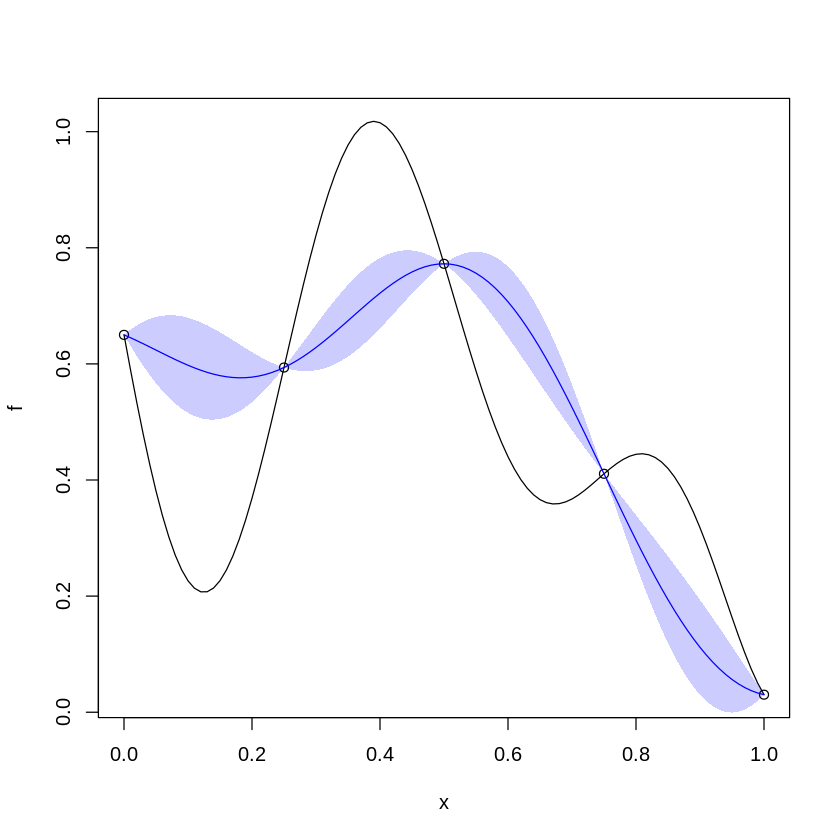

In [6]:
# Predict
.x <- as.matrix(seq(0, 1, , 101))
p.x <- predict(k, .x, TRUE, FALSE)

plot(f)
points(X, y)
lines(.x, p.x$mean, col = 'blue')
polygon(c(.x, rev(.x)), c(p.x$mean - 2 * p.x$stdev, rev(p.x$mean + 2 * p.x$stdev)), border = NA, col = rgb(0, 0, 1, 0.2))

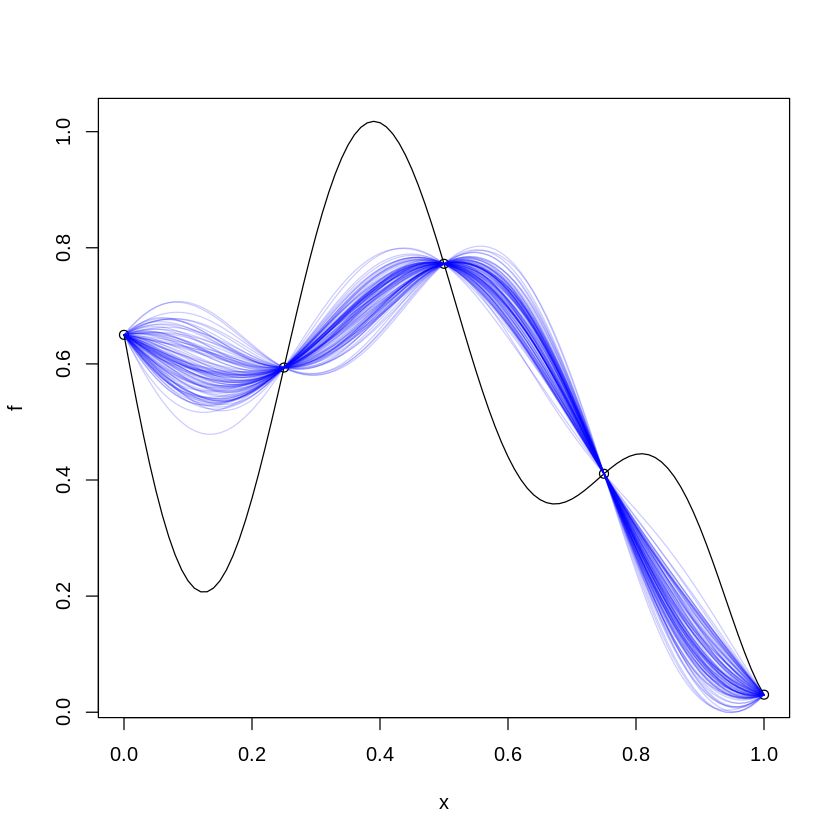

In [7]:
# Simulate
s.x <- simulate(k, nsim = 100, seed = 123, x=.x)

plot(f)
points(X,y)
matplot(.x,s.x,col=rgb(0,0,1,0.2),type='l',lty=1,add=T)

# Fit

[1] 0.2416732


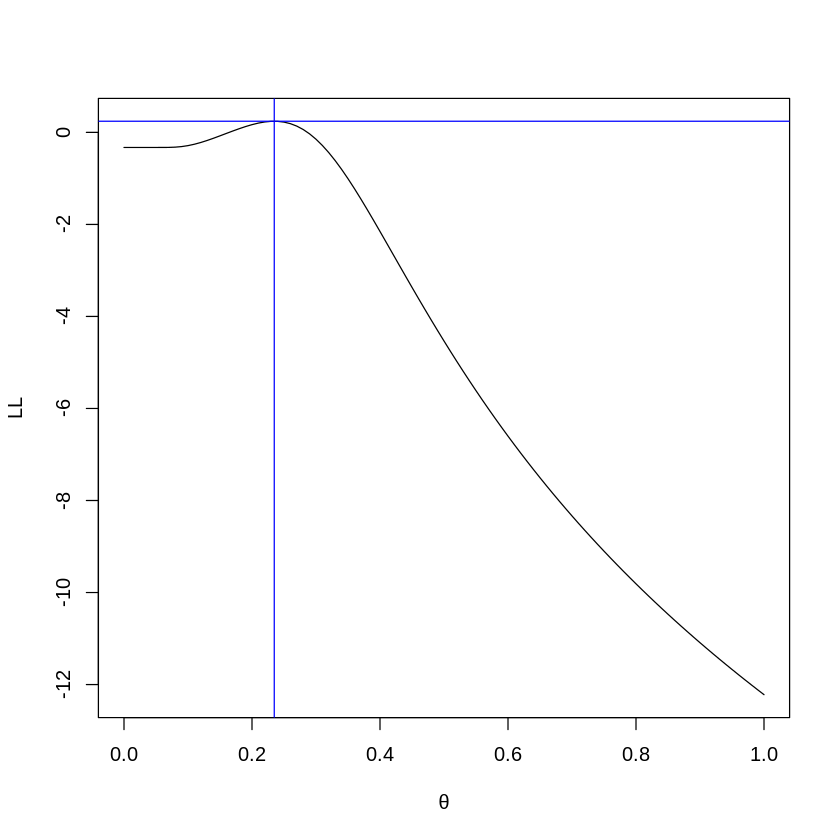

In [8]:
# log-Likelihood (https://libkriging.readthedocs.io/en/latest/math/likelihood.html)
print(k$logLikelihood())

plot( function(t) k$logLikelihoodFun(t)$logLikelihood ,xlab=expression(theta),ylab="LL")
abline(v=k$theta(),col='blue')
abline(h=k$logLikelihood(),col='blue')

[1] 0.0428335


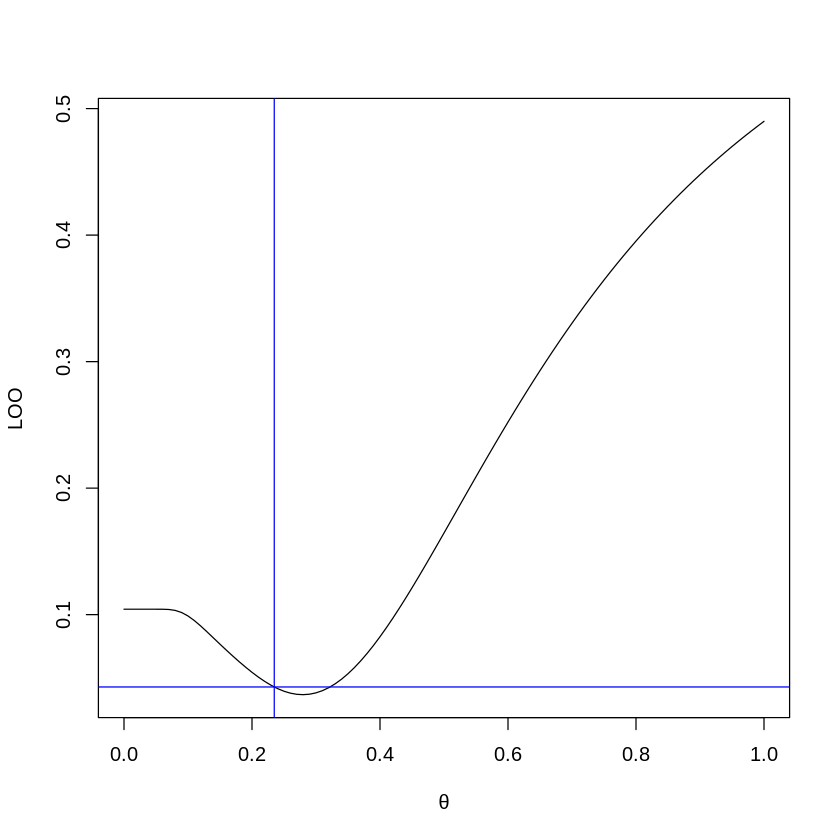

In [9]:
# leave-one-out (https://libkriging.readthedocs.io/en/latest/math/leaveOneOut.html)
print(k$leaveOneOut())

plot( function(t) k$leaveOneOutFun(t)$leaveOneOut ,xlab=expression(theta),ylab="LOO")
abline(v=k$theta(),col='blue')
abline(h=k$leaveOneOut(),col='blue')

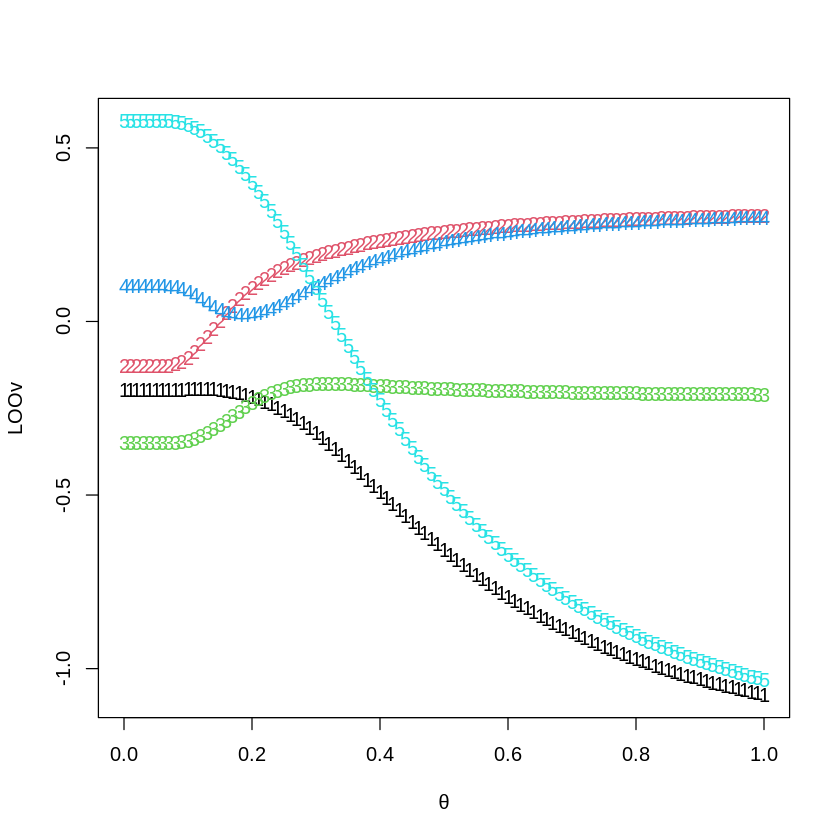

In [10]:
.t = seq(0,1,,101)

matplot(.t, t(sapply(.t, function(t) k$leaveOneOutVec(matrix(t))$mean-k$y()) ),xlab=expression(theta),ylab="LOOv")

[1] 2.123478


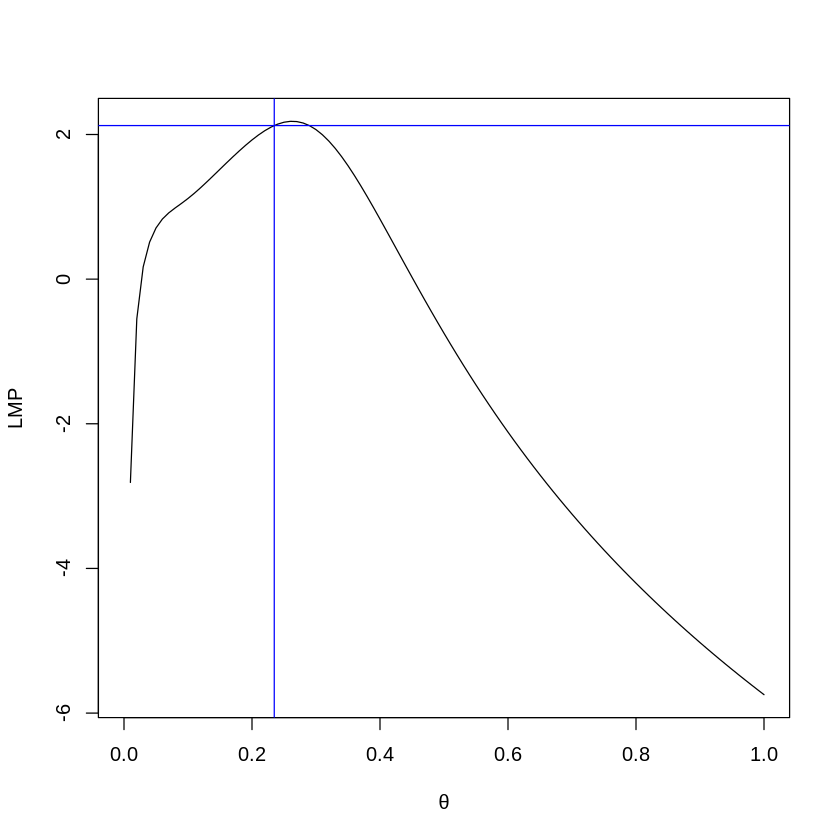

In [11]:
# log-marginal-posterior (https://libkriging.readthedocs.io/en/latest/math/Bayesian.html)
print(k$logMargPost())

plot( function(t) k$logMargPostFun(t)$logMargPost ,xlab=expression(theta),ylab="LMP")
abline(v=k$theta(),col='blue')
abline(h=k$logMargPost(),col='blue')